# Neural Networks (Part 3): Optimizers

In part 3 of this neural networks series of tutorials we'll discuss topics around batching and optimizers:
- Datasets and Dataloaders
- Batching and Batch Sizes
- Optimizers: SGD, Adam, RAdam, AdamW

We'll again load the usual libraries we'll need, set a seed, and set a device for those who'd prefer to work on the GPU. We'll also continue to use our MLP creator function, our parameter counter, and our learning rate finder.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch import nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier
from tqdm.notebook import tqdm

seed = 12
np.random.seed(seed)
torch.manual_seed(seed)

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cpu'

In [4]:
def multilayer_mlp(num_features, num_targets, hidden_sizes, p=0, normalization=None, activation=nn.ReLU()):
    """
    Get an arbitrary MLP model with L=len(hidden_sizes)+1 layers
    Optionally, can include a batchnorm and dropout in each layer, and change the activation function
    """
    def get_leaf_layers(m):
        """Used to flatten the layers out so the model doesn't recursively nest"""
        children = list(m.children())
        if not children:
            return [m]
        leaves = []
        for l in children:
            leaves.extend(get_leaf_layers(l))
        return leaves
    hidden_sizes = [num_features] + hidden_sizes
    n_layers = len(hidden_sizes)
    model = nn.Sequential()
    for l in range(n_layers-1):
        linear = nn.Linear(hidden_sizes[l], hidden_sizes[l+1])
        dropout = None if p == 0. else nn.Dropout(p)
        layer_norm = None if normalization is None else normalization(hidden_sizes[l+1])
        blocks = [linear, layer_norm, activation, dropout]
        layer_block = nn.Sequential(*[layer for layer in blocks if layer is not None])
        model = nn.Sequential(*([model] + [layer_block]))
    output = nn.Sequential(nn.Linear(hidden_sizes[-1], num_targets))
    model = nn.Sequential(*([model] + [output]))
    model = nn.Sequential(*get_leaf_layers(model))
    return model

def lr_find(dataset, model, opt, loss_fn, batch_size=128, **kwargs):
    from torch_lr_finder import LRFinder
    dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size)
    lr_finder = LRFinder(model, opt, loss_fn, device=device)
    lr_finder.range_test(dataloader, **kwargs)
    lr_finder.plot()
    lr_finder.reset()
    
def num_params(model):
    return sum([p.numel() for p in model.parameters()])

## Data Prep: MNIST

For this tutorial we'll want to start going bigger with the data we're using. We'll start by taking baby steps, just using the MNIST dataset. Recall the MNIST dataset consists of 70k grayscale images of handwritten digits, each image of size 28x28 and being labeled with a digit 0-9 (so 10 multiclass classification with 10 classes). The openml link we're downloading the data from has the images in *flattened* form, meaning each 28x28 image gets flattened to a single vector of length 28*28=784. We can always turn the back into images by reshaping. Below is a plot of a random sample of MNIST images.

In [5]:
def get_mnist_data():
    from sklearn.preprocessing import MinMaxScaler
    from sklearn.datasets import fetch_openml
    data = fetch_openml('mnist_784', version=1, return_X_y=True, as_frame=False)
    X = data[0].astype(float)
    X = MinMaxScaler(feature_range=(0,1)).fit_transform(X)
    y = data[1].astype(int)
    return torch.tensor(X).float(), torch.tensor(y).long()

X,y = get_mnist_data()
X.shape, y.shape

(torch.Size([70000, 784]), torch.Size([70000]))

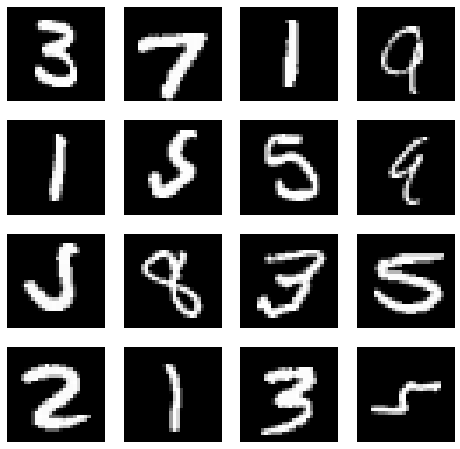

In [6]:
def plot_images(X, n=4):
    from matplotlib import cm
    idx = np.random.choice(len(X), n**2, replace=False)
    _, ax = plt.subplots(nrows=n, ncols=n, figsize=(8, 8))
    cnt = 0
    for i in range(n):
        for j in range(n):
            ax[i, j].imshow(X[idx[cnt]].reshape(28, 28), aspect='auto', cmap=cm.gray)
            ax[i, j].axis('off')
            cnt += 1
    plt.show()
    
plot_images(X.cpu().numpy(), n=4)

We might as well go ahead and split the dataset up into training and test sets. Following the convention with this dataset, we'll take 60k images for training and 10k images for testing.

While we're at it, let's go ahead and see how well a baseline, no frills classical model does classifying the images in this dataset. We'll use the random forest with the defaults (100 trees). Looks like it can already classify MNIST images with 96.8% accuracy! That's a pretty high bar to beat.

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=1/7)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

(torch.Size([60000, 784]),
 torch.Size([10000, 784]),
 torch.Size([60000]),
 torch.Size([10000]))

In [8]:
model = RandomForestClassifier(random_state=seed)
model.fit(X_train.cpu().numpy(), y_train.cpu().numpy())
model.score(X_test.cpu().numpy(), y_test.cpu().numpy())

0.9679

## Datasets, Dataloaders, and Batches

So far we've been working with data the same way one might do in sklearn, having an input data array `X` and an output data array `y` that we keep track of separately. Pytorch natively prefers, however, that data examples `x,y` be grouped together in pairs, so that the dataset is a list of these input-output example pairs:
```
dataset = [(X[0], y[0]), (X[1], y[1]), ..., (X[N-1], y[N-1])]
```
Pytorch likes it this way because it makes it easier to convert datasets to dataloaders and work in batches, something we'll get to shortly. 

We can pretty easily create pytorch compatible datasets by creating a list of tuples for both our training and test sets. We'll call the training dataset `train_set` and the test dataset `test_set`.

In [9]:
train_set = [(X_train[i], y_train[i]) for i in range(len(y_train))]
test_set = [(X_test[i], y_test[i]) for i in range(len(y_test))]

With our data in this form we can talk about dataloaders, probably the most important data structure in pytorch. Basically put, a dataloader splits data up into **batches** according to a specified **batch size**. We'll deal with why we might want to do this in a second. First, the how.

To convert a dataset into a dataloader, we use the `torch.utils.data.DataLoader` class, passing in the dataset, a batch size, and other optional arguments we'll cover as we go. Here, we'll convert our `train_set` and `test_set` objects into dataloaders `train_loader` and `test_loader`. For now we'll use a batch size of 32. We'll also pass in `shuffle=True`, which tells pytorch to shuffle the datasets randomly, a good idea for training models later on.

In [10]:
train_loader = DataLoader(train_set, batch_size=32, shuffle=True)
test_loader = DataLoader(test_set, batch_size=32, shuffle=True)

What exactly is a dataloader though? Basically, a dataloader takes your dataset and splits it into chunks each with `batch_size` many data examples. Each iteration of the dataloader then gives `X, y` pairs of shuffled examples, but `batch_size` many of them at a time. It does this until it gets through the whole dataset, at which point it starts over again. Note that by using the datasets approach above you're guaranteed each `x,y` pair will be the appropriate feature-target pair, i.e. the data samples will always shuffle together in input-output pairs.

One subtlety to get used to is that pytorch dataloaders are python *generator* objects. Roughly speaking, a generator is a list that hasn't been instantiated. All you can do is grab the next item, iteratively, using `next(iter(dataloader))`. You can also loop over if using `for X, y in dataloader` and it'll work the usual way. Just remember that, as a generator, the `dataloader` object can't be indexed into without converting it into a list first.
 
Here's an example of grabbing the next *batch* from a dataloader. Notice that the 0-dimension is size 32, which is our batch size. For inputs `X`, the 1-dimension is the feature number, in our case 784. For targets `y`, the 1-dimension (if any) will be the number of classes or targets.

In [11]:
X, y = next(iter(train_loader))
X.shape, y.shape

(torch.Size([32, 784]), torch.Size([32]))

In [12]:
i = 0
for X, y in train_loader:
    print(X.shape, y.shape)
    i += 1
    if i == 5:
        break

torch.Size([32, 784]) torch.Size([32])
torch.Size([32, 784]) torch.Size([32])
torch.Size([32, 784]) torch.Size([32])
torch.Size([32, 784]) torch.Size([32])
torch.Size([32, 784]) torch.Size([32])


If you want the whole dataloader in memory at once you first have to convert it into a list using `list(dataloader)`. You usually will not want to do this though, as we'll see. It can be useful for telling us how many batches are in the dataset though. In our case, it looks like there are 1875 batches in the training set when using a batch size of 32. That makes sense, given that `32*1875=60,000` is our training set size. It won't always be exact like this. Sometimes you'll have leftover data in the last batch when the batch number and the dataset size don't divide evenly. This is true, for example, with the test set. There, `32*313=10,016`. But the test set size is 10,000. Evidently the last batch only contains `10,000-32*(313-1)=16` examples.

In [13]:
print(f'# batches in training set: {len(list(train_loader))}')
print(f'# batches in test set: {len(list(test_loader))}')

# batches in training set: 1875
# batches in test set: 313


Why would we want to bother with all this batching stuff though when we can just work with the whole dataset at once? The simple reason is, for any reasonably large dataset, doing deep learning slows to a crawl if you try to feed in all the data at once. You'll find that it takes *forever* to do a forward pass of the network. Worse, you might (and often will) run out of memory either on the CPU or the GPU. 

For example, the MNIST dataset is considered "small" by today's deep learning standards. But if you try to pass all 70k images through any decent deep learning model at one time you'll probably slow your performance way down. Assuming 4 bytes per number, a 28x28 image will take up `4*28*28=3186` bytes, or 3.186 kB of memory. That means 70,000 images will take up 219,520,000 bytes, or 219 MB. That doesn't seem like a lot, but it's enough to slow down your performance a lot, especially when you're passing that much data through a model of millions of parameters for many iterations.

A clever way around this problem is to not pass through *all* the data in one forward pass of the network, but to only pass through smaller batches of it at a time. This is what dataloaders allow you to do. They're an efficient way to feed data to your model in a way that keeps up system performance and avoids crashing your CPU/GPU.

This isn't the only reason batching is a good idea though. It turns out that batching your data also acts as a form of regularization! Essentially, when you feed data through a neural network in batches, it will only update the gradients based on the data in *that particular batch*. But the data in any given batch is just a random subsample of the total dataset, meaning it's only a *guess* of what the best, true gradients should be. The smaller the batch size, the more random this estimate will be. A batch size of 1 will mean *a lot* of regularization and randomness during training, and a batch size of `N`, the dataset size, will mean no regularization or randomness at all.

The introduction of the batch size thus means we've got a new hyperparameter to tune when training models. How should it be tuned? The emerging rule of thumb from experiments is that you want to pick the *largest* batch size that will still allow your data to fit in memory without slowing down system performance. If you're training on the GPU, that means you want to pick the largest batch size that will let your data and model fit on the GPU without getting a Cuda out of memory error. There's no reason you *have* to do it this way. Just that experiments have shown that models tend to train the best when you use as large a batch size as possible, without crashing your system or GPU.

**Note:** It's also worth mentioning that there is a rough, rule of thumb tradeoff between learning rate and batch size. Essentially, if you multiply the batch size by a factor `k`, you'll want to make sure to also multiply the learning rate by that same factor `k` to ensure good training. For example, if you double the batch size, you should also double the learning rate, otherwise you'll be training with a smaller learning rate than you have to. If you halve the batch size, you should halve the learning rate, otherwise your model may fail to converge. This is just a rule of thumb though. Other rules of thumb have been proposed as well, but this linear rule is the easiest to remember. But at the end of the day, don't forget you always have the learning rate finder to help you out.

In deep learning, when working with batches, a complete cycle through all of the data is called an **epoch**. When the training dataloader has exhausted all the batches and starts over, the model is said to have completed one epoch of training. Note the subtle difference between an *epoch* and an *iteration*. An iteration is how many times the model goes through the loop, not how many times it goes through the dataset. Before now this distinction didn't matter, since each iteration was also an epoch, as we were passing through all the data at once.

Since we've covered dataloaders, we've covered the last *major* piece we need to add to our `train_model` function. Instead of taking in data in `X_train, y_train, X_test, y_test` format, we'll want to modify the function to take in dataloaders in `train_loader`, `test_loader` format. This also means we'll need to modify the training loop to iterate over these dataloaders separately in batches, first training and then inference. That means a double loop. Can't be avoided unfortunately.

In [14]:
def train_model(train_loader, model, opt, loss_fn, num_epochs, test_loader=None, scheduler=None):
    for epoch in tqdm(range(num_epochs)):
        # training
        model = model.train()
        for X, y in train_loader:
            X = X.to(device)
            y = y.to(device)
            opt.zero_grad()
            yhat = model(X)
            loss = loss_fn(yhat, y)
            loss.backward()
            opt.step()
            if scheduler is not None:
                scheduler.step()
        avg_train_loss = loss / len(train_loader)
        # inference
        if test_loader is not None:
            model = model.eval()
            for X, y in test_loader:
                X = X.to(device)
                y = y.to(device)
                yhat = model(X)
                test_loss = loss_fn(yhat, y)
            avg_test_loss = test_loss / len(test_loader)
        else:
            avg_test_loss = None
        if num_epochs <= 10 or epoch % (num_epochs // 10) == 0:
            print(f'epoch = {epoch} \t\t train loss = {avg_train_loss} \t\t test loss = {avg_test_loss}')
    if not num_epochs <= 10 and not epoch % (num_epochs // 10) == 0:
        print(f'epoch = {epoch} \t\t train loss = {avg_train_loss} \t\t test loss = {avg_test_loss}')
    return model

Just to see how things look, let's create and train a light softmax regression model (i.e. linear regression with a softmax activation) on MNIST really quick. Recall that when doing multiclass classification with the cross entropy loss, we leave off the softmax from the model and just feed in the logits directly. This effectively means that our model is using just a single linear layer.

We'll use a batch size of 128 (I could possibly go larger than that, but I didn't try). Let's train for 10 epochs and then check the test set accuracy.

In [15]:
num_features = 28 * 28
num_targets = 10

model = nn.Linear(num_features, num_targets)
model

Linear(in_features=784, out_features=10, bias=True)

In [16]:
batch_size = 128

train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_set, batch_size=batch_size, shuffle=True)

  0%|          | 0/100 [00:00<?, ?it/s]

Learning rate search finished. See the graph with {finder_name}.plot()
LR suggestion: steepest gradient
Suggested LR: 5.34E-01


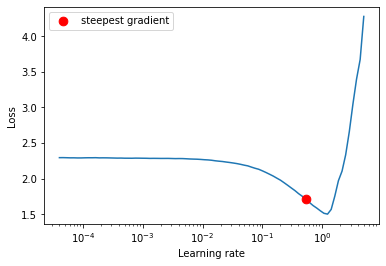

In [17]:
opt = torch.optim.SGD(model.parameters(), lr=1)
loss_fn = nn.CrossEntropyLoss()
lr_find(train_set, model, opt, loss_fn, batch_size=batch_size, start_lr=1e-5, end_lr=10)

In [18]:
num_epochs = 10
opt = torch.optim.SGD(model.parameters(), lr=0.5)
loss_fn = nn.CrossEntropyLoss()
model = train_model(train_loader, model, opt, loss_fn, num_epochs, test_loader=test_loader, scheduler=None)

  0%|          | 0/10 [00:00<?, ?it/s]

epoch = 0 		 train loss = 0.0007540841470472515 		 test loss = 0.005086470395326614
epoch = 1 		 train loss = 0.00048541376600041986 		 test loss = 0.003749304451048374
epoch = 2 		 train loss = 0.0007025026716291904 		 test loss = 0.004168649669736624
epoch = 3 		 train loss = 0.0003640296054072678 		 test loss = 0.00046293591731227934
epoch = 4 		 train loss = 0.0009896220872178674 		 test loss = 0.004241964314132929
epoch = 5 		 train loss = 0.0006413895171135664 		 test loss = 0.00967457052320242
epoch = 6 		 train loss = 0.0006371730705723166 		 test loss = 0.010192619636654854
epoch = 7 		 train loss = 0.0005846598651260138 		 test loss = 0.0007608421146869659
epoch = 8 		 train loss = 0.0005498883547261357 		 test loss = 0.001872978638857603
epoch = 9 		 train loss = 0.0008496567024849355 		 test loss = 0.0036680528428405523


Notice how quickly the model trained. It would be *much* slower if we tried to train it without using batches. Try it if you want. Take batch sizes of `len(train_set)` and `len(train_set)` and see how much slower training is.

The loss barely changed over 10 epochs, but it does look pretty low on both ends. There's a hint the model is *underfitting* since the test loss appears so much lower than the training loss across much of training. That's not surprising, given we're just using softmax regression, which is logistic regression for multiple classes.

Let's go ahead and write a function `get_scores` that can score our model using dataloaders with any sklearn score function `score_fn` we might pass in. Notice the loops look almost exactly the same as the training loop in the `train_model` function above. The main difference is that we're not calling `loss.backward()`, nor are we stepping the optimizer or the scheduler. This is what a standard inference loop looks like. Notice how we also set the model to eval mode at the top of the function.

We'll use the function here to get the model accuracy on our training and test sets. It looks like we're already at about 92% test accuracy with this simple softmax regression model. Adding hidden layers will probably help up it even more, hopefully to get above the random forest accuracy of 96.8% from above.

In [19]:
def get_scores(train_loader, model, score_fn, test_loader=None):
    # score_fn must be any valid sklearn scoring function that acts directly on labels
    # currently only works for multiclass classification models, need to modify for binary or regression
    model = model.eval()
    train_scores = []
    for X, y in train_loader:
        X = X.to(device)
        y = y.to(device)
        yhat = model(X).detach()
        y_pred = yhat.argmax(dim=-1).long()
        score = score_fn(y.flatten().cpu().numpy(), y_pred.flatten().cpu().numpy())
        train_scores.append(score)
    print(f'avg train {score_fn.__name__}: {sum(train_scores) / len(train_scores)}')
    if test_loader is not None:
        test_scores = []
        for X, y in test_loader:
            X = X.to(device)
            y = y.to(device)
            yhat = model(X).detach()
            y_pred = yhat.argmax(dim=-1).long()
            score = score_fn(y.flatten().cpu().numpy(), y_pred.flatten().cpu().numpy())
            test_scores.append(score)
        print(f'avg test {score_fn.__name__}: {sum(test_scores) / len(test_scores)}')

get_scores(train_loader, model, accuracy_score, test_loader=test_loader)

avg train accuracy_score: 0.9288268479033405
avg test accuracy_score: 0.9215783227848101


## Optimizers

Changing from processing the entire dataset at once to just processing it in batches introduces new subtlety to training models that we didn't have before. When processing the full dataset, gradient descent works exactly one way. At each iteration the gradients were exact, meaning the model truly was moving in the "best direction" with each optimizer step, relative to the training dataset. But now we're moving to just training the model on batches. That means that each each iteration the gradients are calculated from that individual batch alone (a random sample of the training set), and hence they're no longer the exact "true" gradients from the full training set. 

### Stochastic Gradient Descent (SGD)

Since the gradients are used to decide which direction to step the update, and by how much to step, that means that we're now taking more noisy, random steps towards the minimum rather than marching straight in. So now our naive use of gradient descent, i.e. `SGD`, means something a bit different than it did before.

This new version of gradient descent is called **stochastic gradient descent** or **SGD**, hence the reason for the pytorch name `SGD`. The inclusion of "stochastic" in the name refers to the fact that we're now using noisy gradients, which will tend to make our march to the minimum more noisy than before. That means a lower learning rate will be needed to not step "too far" off the mark, hence the longer the model will have to train to converge. It's kind of like the difference between walking home sober, and walking home a little drunk. When you're drunk (more noise), you'll tend to stagger around more and take longer tot get home than when you're sober (less noise).

This extra randomness in gradient descent seems mostly undesired, since it means lower learning rates and longer training times. One way to control it is by tuning the batch size. The higher the batch size, the less randomness the optimizer will have, since it'll have a better estimate of its gradients and hence take better steps towards the minimum. A batch size of 1 is the *most random* version of SGD you can have, while a batch size of N is the *least random*.

You've already seen it, but here again is an example of how to implement standard, vanilla SGD.

In [24]:
opt = torch.optim.SGD(model.parameters(), lr=0.01)

### SGD with Momentum

Another way to tweak SGD to be less random is to use a concept called **momentum**. The idea is this: Our gradient estimates are noisy, so maybe we should smooth them out to make them less noisy. Instead of using the gradients directly to update the parameters, we'll use the smoothed gradients to update them. The smoothed gradients are calculated in a time series sense using *exponential smoothing*. This technique looks at all gradients calculated during training and takes an exponentially weighted average of them, so that the most recent gradients get higher weights than the least recent ones. The effect of this is kind of like a sliding window: to smooth the gradients out and make them less noisy.

In more formal language SGD with momentum works as follows. Given a model with parameters $\boldsymbol{\theta}$, a learning rate $\alpha$, and a **momentum** hyperparameter $\mu$, each time step $t$ of the optimizer looks like
$$
\begin{aligned}
    \boldsymbol{m}_t & = \mu \boldsymbol{m}_{t-1} + \frac{dL(\boldsymbol{\theta}_t)}{d\boldsymbol{\theta}}, \\
    \boldsymbol{\theta}_t & = \boldsymbol{\theta}_{t-1} - \alpha \boldsymbol{m}_t.
\end{aligned}
$$
The first line is the exponential smoothing, where we calculate the smoothed gradient $m_t$ that will then be fed into the gradient descent update in the second line. The momentum term $\mu$ controls how much smoothing we want. Setting $\mu=0$ means no smoothing, just regular SGD. Setting $\mu$ infinitely high means infinite smoothing, i.e. the gradients $m_t$ won't update at all and the model won't learn. 

Note that by convention $m_0 \equiv 0$, since it needs an initialization. This creates a slight bias towards zero in the gradient estimates early in training, but the effect dies out after a few iterations, so we can ignore it.

In pytorch, using SGD with momentum just means adding an extra keyword `momentum` to SGD, which is the same as $\mu$ in the equations above. For example, here's how to use SGD with momentum $\mu=1$.

In [23]:
opt = torch.optim.SGD(model.parameters(), lr=0.01, momentum=1)

### Adam

There were many other optimizers that came after SGD, e.g. RProp, RMSProp, and Adagrad. These SGD variants were popular for a few years, but they now all seem to be largely supplanted in deep learning. What ended up replacing them all was Adaptive Moment Estimation, or **Adam** for short. Adam was published in 2014, and even in 2022 it's not too out there to say that SGD and Adam are by far the most common optimizers used for deep learning, though newer improvements to Adam like RAdam and AdamW have gained some ground in the past few years.

Adam works by not just using momentum to smooth the gradients, but to smooth their variances as well. The combination of smoothing both gradients and their variances has been shown to substantially speed up training even for the smallest batch sizes. The way Adam does the smoothing and updating is somewhat unusual though compared to what we've seen. I'll outline the steps, but don't worry if you don't understand what they're doing very well. 

Below is a more mathy explanation of how Adam works. If you're not inclined, you can feel free to skip to the bottom of this cell if you wish. Do at least pay attention to what the hyperparameters $\beta_1, \beta_2, \varepsilon$ do at a high level though, should you ever care to tweak them during training (usually you won't).

Instead of just keeping track of the smoothed gradients $m_t$, Adam also keeps track of the smoothed gradient variances $v_t$ (technically the gradient second moments). Annoyingly though, Adam calculates these smoothing terms in a slightly different way than SGD with momentum does,
$$\boldsymbol{m}_t = \beta_1 \boldsymbol{m}_{t-1} + (1-
\beta_1) \frac{dL(\boldsymbol{\theta}_t)}{d\boldsymbol{\theta}},$$
$$\boldsymbol{v}_t = \beta_2 \boldsymbol{v}_{t-1} + (1 - \beta_2)\bigg(\frac{dL(\boldsymbol{\theta}_t)}{d\boldsymbol{\theta}}\bigg)^2.$$

Note the square of the gradient in the $\boldsymbol{v}_t$ term is calculated *elementwise*. The values $\beta_1, \beta_2$ are the momentum hyperparameters, but in this formulation they only take values between 0 and 1. Values of $\beta=0$ mean no smoothing, while values of $\beta=1$ mean infinite smoothing. The original Adam paper recommends (and these are the pytorch defaults) beta values of $\beta_1=0.9$ and $\beta_2=0.999$. 

Notice that this is *a lot* of smoothing, especially on the variances. To get an idea how much smoothing it's doing, a good rule of thumb is that the number of previous iterations $n$ it's averaging over at any time $t$ is the last
$$n \approx \frac{1}{1 - \beta}$$
iterations. So for $\beta_1=0.9$, $m_t$ is averaging over about $n\approx 10$ iterations. For $\beta_2=0.999$, $v_t$ is averaging over about $n\approx 1000$ iterations. Note these are iterations (the number of batches the model sees), not epochs. Each epoch can have thousands or millions of iterations. Another effect of this is that the biases die off pretty quickly, since $m_0=0$ will be forgotten in just 10 iterations, and $v_0=0$ in just 1000 iterations.

Despite the fact that the biases die off quickly, Adam implements **bias correction** on these smoothed gradients to ensure that the $t=0$ terms have no impact early on. Bias correction is done by dividing each smoothed estimate by a factor $1/(1-\beta)$, like so:
$$
\begin{aligned}
    \boldsymbol{\hat m}_t & = \frac{\boldsymbol{m}_t}{1 - \beta_1^t}, \\
    \boldsymbol{\hat v}_t & = \frac{\boldsymbol{v}_t}{1 - \beta_2^t}.
\end{aligned}
$$

Since we showed the bias terms $m_0,v_0$ die off pretty quickly in training, these corrections really don't do that much, as $\beta^t \approx 0$ when $t$ gets large, hence $\boldsymbol{\hat m}_t \approx \boldsymbol{m}_t$ and $\boldsymbol{\hat v}_t \approx \boldsymbol{v}_t$. Nevertheless, these terms are still included in the algorithm.

The final step is to update the parameters. This will be done as follows.
$$\boldsymbol{\theta}_t = \boldsymbol{\theta}_{t-1} - \alpha \frac{\boldsymbol{\hat m}_t}{\sqrt{\boldsymbol{\hat v}_t}+\varepsilon}.$$
We use the $\boldsymbol{\hat m}_t$ term here just like we did $\boldsymbol{m}_t$ in SGD with momentum. The main difference is we're now (elementwise) dividing by the gradient "standard deviations" $\sqrt{\boldsymbol{\hat v}_t}$. Since these values can become zero (why not) and make the denominator zero, we'll add a very small numerical value $\varepsilon$ to keep that from happening. This ensures that even if $\boldsymbol{\hat v}_t \approx 0$ that the denominator will never be zero, which is better for the optimizer's numerical stability. The default value for epsilon is $\varepsilon=10^{-8}$, a really small number indeed.

We can optionally add in **weight decay** to Adam just like with SGD. It turns out though that the authors implemented weight decay incorrectly, using the same weight decay factor as used with SGD. It'll still work mostly well in practice if you use it, but it's not *really* weight decaying correctly anymore, since the smoothing terms actually change what the gradients of the loss look like, and hence what the weight decay penalty term looks like. A newer optimizer called AdamW will rectify this little deficiency.

Even still, Adam is still the most popular optimizer used to train deep learning models, and we'll probably end up using it most of the time in these tutorials. Adam is a pretty fast optimizer, allowing you to use learning rates much higher than SGD would typically let you get away with.

In pytorch, we can implement Adam using `torch.optim.Adam`. Here's an example, where we're using the default values for the betas and epsilon. (You don't actually have to pass them in if they're default values. I just do it so you can see them if you ever want to tweak them.)

In [33]:
opt = torch.optim.Adam(model.parameters(), lr=0.01, betas=(0.9, 0.999), eps=1e-8, weight_decay=0)

The next two optimizers we'll mention are newer. They're just minor tweaks to Adam designed to correct some of its deficiencies. They mostly still work exactly the same as Adam does. Nevertheless, they are becoming more widely used.

### AdamW

AdamW works exactly the same way Adam does, except it does one tweak at the beginning of each step to make weight decay come out correctly (recall that it doesn't come out quite correctly for Adam). 

The calculations for $\boldsymbol{\hat m}_t, \boldsymbol{\hat v}_t$ are exactly the same. The only difference is that we tweak the gradient update step at the end by subtracting the correction term shown in red below,
$$\boldsymbol{\theta}_t = \boldsymbol{\theta}_{t-1} - \alpha \frac{\boldsymbol{\hat m}_t}{\sqrt{\boldsymbol{\hat v}_t}+\varepsilon} \color{red}{- \alpha \lambda \boldsymbol{\theta}_{t-1}}.$$

This small correction ensures that weight decay for Adam works exactly like it's supposed to, i.e. that the L2 penalty term from the regularized loss function gives the correct weight decay penalty term in the gradient update.

Notice if $\lambda=0$, we just get the regular Adam update. That is, AdamW reverts to just plain Adam if no weight decay is used.

Implementing AdamW in pytorch works exactly the way Adam does, even taking in the same parameters. Here's an example using the defaults, with a light weight decay added.

In [37]:
opt = torch.optim.AdamW(model.parameters(), lr=0.01, betas=(0.9, 0.999), eps=1e-8, weight_decay=0.0001)

### RAdam

One strange feature of using Adam with some of the modern architectures we haven't covered yet, like transformers, is the need for *warmups* early in training. Essentially, with some types of neural network architectures, Adam has a tendency early in training to diverge or converge to poor minima. What seems to be happening is that the variance term $v_t$ is getting too small early in training, causing the *effective learning rate*
$$\alpha_{\text{eff}} \equiv \frac{\alpha}{\sqrt{v_t} + \varepsilon}$$
to get really large, which as you'll recall means that training will fail to converge since the optimizer just bounces around the loss surface. This problem only seems to happen early in training, with $v_t$ eventually settling down to larger values later on, bringing the effective learning rate back down again. Nevertheless, this tendency to bounce around early in training can mean longer training times or having to tune the hyperparameters more.

One way around this warmups issue is to use a learning rate scheduler that includes a warmup period. That is, instead of starting with the specified learning rate, it starts training with a much lower learning rate, and ramps up to the specified learning rate after so many iterations. One example of a scheduler that does this is one-cycle, which starts low and ramps up the learning rate to the max over a specified number of iterations (usually something like a third of an epoch). If you use Adam with a one-cycle scheduler, you'll probably be fine.

Another way around this is to just go ahead and "fix" Adam to keep this early divergence issue from happening in the first place, essentially baking a warmup period into the optimizer directly. This is what Rectified Adam, or **RAdam**, does. It again essentially reproduces Adam except for some tweaking, the introduction of a *rectifier* term $\rho_t$ that's designed to keep the effective learning rate from blowing up early in training.

$$\color{black}{\rho_{\infty} = \frac{2}{1-\beta_2}-1}$$
$$\color{black}{\rho_t = \rho_{\infty} - 2t\frac{\beta_2^t}{1-\beta_2^t}}$$
$$\color{black}{r_t = \sqrt{\frac{(\rho_t-4)(\rho_t-2)\rho_{\infty}}{(\rho_{\infty}-4)(\rho_{\infty}-2)\rho_t}}}$$
$$\boldsymbol{\theta}_t = \boldsymbol{\theta}_{t-1} - \alpha \frac{\boldsymbol{\hat m}_t}{\sqrt{\boldsymbol{\hat v}_t}+\varepsilon} \color{red}{r_t}$$

In [107]:
beta = 0.999
rho_inf = 2/(1-beta)-1
print(f'beta_2 = {beta}')
print(f'rho_inf = {rho_inf}')
print(f'{"t":<15} {"rho_t":<25} {"r_t":<25} {"rho_t > 5":<15}')
print('-'*14*6)
for t in [1, 10, 100, 1000, 10_000, 100_000]:
    rho_t = rho_inf - 2*t*beta**t/(1-beta**t)
    r_t = np.sqrt(((rho_t-4)*(rho_t-2)*rho_inf) / ((rho_inf-4)*(rho_inf-2)*rho_t))
    print(f'{t:<15} {rho_t:<25} {r_t:<25} {rho_t > 5: <15}')

beta_2 = 0.999
rho_inf = 1998.9999999999982
t               rho_t                     r_t                       rho_t > 5      
------------------------------------------------------------------------------------
1               1.0                       0.038797750152842335      0              
10              9.98349177230557          0.04899801344710748       1              
100             98.33294432272578         0.21533543653820142       1              
1000            835.9673756107934         0.6453256523380656        1              
10000           1998.0964922659898        0.9997733049343513        1              
100000          1998.9999999999982        1.0                       1              


In [46]:
torch.optim.RAdam?

In [44]:
# RAdam

<IPython.core.display.Latex object>

In [ ]:
# 6-layer NN 784-2500-2000-1500-1000-500-10 (on GPU) [elastic distortions]
# accuracy = 99.65%